In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V_A_change
import pandas as pd

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# before LED on, aborts in LED on vs off are different?

In [14]:

df[df['LED_trial'] == 0].shape[0]

64377

In [19]:
df_led_off_truncated_aborts['timed_fix']

27296     0.530273
27315     0.754883
27318     0.580078
27321     0.533203
27323     0.612305
            ...   
245246    0.434570
245304    0.723633
245308    1.055664
245313    1.034180
245315    0.782227
Name: timed_fix, Length: 10051, dtype: float64

0.1561271882815291 0.20121951219512196


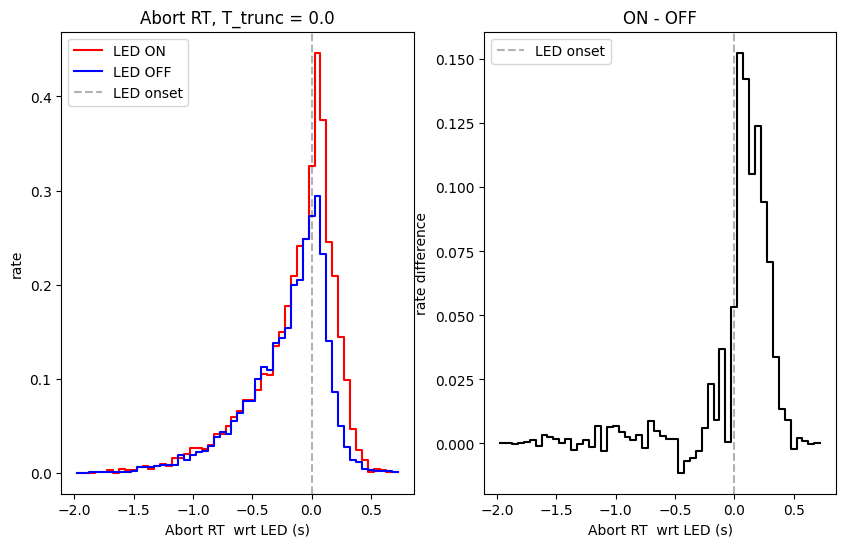

In [25]:
T_trunc = 0.0
 
# remove rows from df, where LED_trial, timed_fix, intended_fix, LED_onset_time can be nan and see how many rows were dropped
df = df.dropna(subset=['LED_trial', 'timed_fix', 'intended_fix', 'LED_onset_time'])


df_led_on_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_truncated_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]

frac_of_aborts_led_on = df_led_on_truncated_aborts.shape[0] / df[df['LED_trial'] == 1].shape[0]
frac_of_aborts_led_off = df_led_off_truncated_aborts.shape[0] / df[df['LED_trial'] == 0].shape[0]

print(frac_of_aborts_led_off, frac_of_aborts_led_on) # truncated aborts, 3% increase

abort_rt_wrt_LED_ON = df_led_on_truncated_aborts['timed_fix']  - (df_led_on_truncated_aborts['intended_fix'] - df_led_on_truncated_aborts['LED_onset_time'])
abort_rt_wrt_LED_OFF = df_led_off_truncated_aborts['timed_fix']  - (df_led_off_truncated_aborts['intended_fix'] - df_led_off_truncated_aborts['LED_onset_time'])


bin_width = 0.05
bins = np.arange(-2, 0.8, bin_width)
abort_on_hist, _ = np.histogram(abort_rt_wrt_LED_ON, bins=bins, density=True)
abort_off_hist, _ = np.histogram(abort_rt_wrt_LED_OFF, bins=bins, density=True)

abort_on_hist *= frac_of_aborts_led_on
abort_off_hist *= frac_of_aborts_led_off
t_pts = bins[:-1] + bin_width/2

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.step(t_pts, abort_on_hist, label='LED ON', color='r')
plt.step(t_pts, abort_off_hist, label='LED OFF', color='b')

plt.axvline(0, color='k', linestyle='--', label='LED onset', alpha=0.3)   
plt.legend()
plt.xlabel('Abort RT  wrt LED (s)')

plt.ylabel('rate')
plt.title(f'Abort RT, T_trunc = {T_trunc}')

plt.subplot(1, 2, 2)   
plt.title('ON - OFF')
plt.step(t_pts, abort_on_hist - abort_off_hist, color='k')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.xlabel('Abort RT  wrt LED (s)')

plt.ylabel('rate difference')
plt.legend()

(-0.5, 0.0)

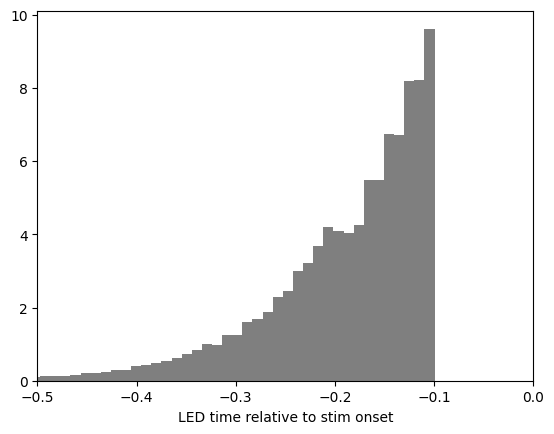

In [28]:
plt.hist(-1*df['LED_onset_time'], bins=100, alpha=0.5, density=True, color='k');
plt.xlabel('LED time relative to stim onset')
plt.xlim(-0.5, 0)

# No normalization?

Text(0.5, 0, 'Abort RT  wrt LED (s)')

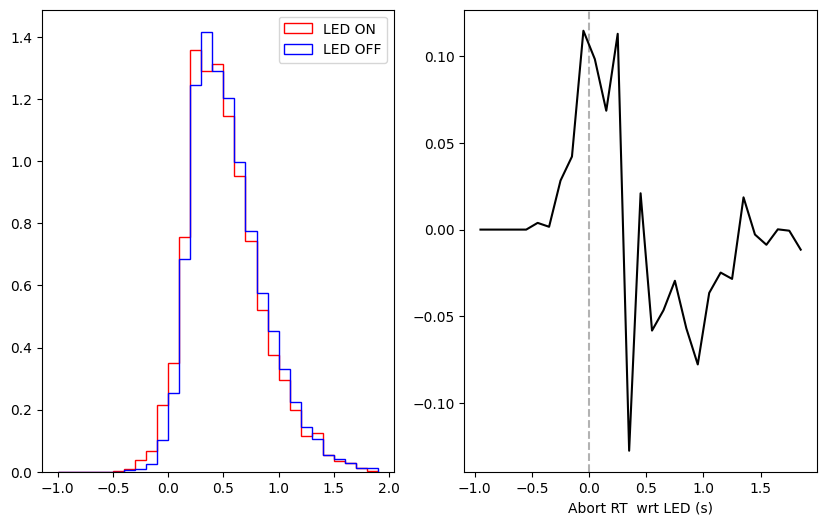

In [72]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(abort_rt_wrt_LED_ON, bins=bins, color='r', density=True, histtype='step', label='LED ON')
plt.hist(abort_rt_wrt_LED_OFF, bins=bins, color='b', density=True, histtype='step', label='LED OFF')
plt.legend()


plt.subplot(1, 2, 2)
on_hist, _ = np.histogram(abort_rt_wrt_LED_ON, bins=bins, density=True)
off_hist, _ = np.histogram(abort_rt_wrt_LED_OFF, bins=bins, density=True)

plt.plot(t_pts, on_hist - off_hist, color='k')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.xlabel('Abort RT  wrt LED (s)')

# is it statistically sig?

In [8]:
# from tqdm import tqdm
# N_shuffles = int(10e3)

# on_minus_off_shuffled = np.zeros((N_shuffles, len(t_pts)))

# for s in tqdm(range(N_shuffles)):
#     # make a value copy of df
#     df_shuffled = df.copy()

#     # shuffle LED_trial labels
#     df_shuffled['LED_trial'] = np.random.permutation(df['LED_trial'].values)

#     # on truncated aborts shuffled
#     df_led_on_truncated_aborts_shuffled = df_shuffled[ (df_shuffled['LED_trial'] == 1) & (df_shuffled['timed_fix'] < df_shuffled['intended_fix']) & (df_shuffled['timed_fix'] > T_trunc) ]
#     df_led_off_truncated_aborts_shuffled = df_shuffled[ (df_shuffled['LED_trial'] == 0) & (df_shuffled['timed_fix'] < df_shuffled['intended_fix']) & (df_shuffled['timed_fix'] > T_trunc) ]

#     frac_of_aborts_led_on_shuffled = df_led_on_truncated_aborts_shuffled.shape[0] / df_shuffled[df_shuffled['LED_trial'] == 1].shape[0]
#     frac_of_aborts_led_off_shuffled = df_led_off_truncated_aborts_shuffled.shape[0] / df_shuffled[df_shuffled['LED_trial'] == 0].shape[0]

#     abort_rt_wrt_LED_ON_shuffled = df_led_on_truncated_aborts_shuffled['timed_fix'] - df_led_on_truncated_aborts_shuffled['LED_onset_time']
#     abort_rt_wrt_LED_OFF_shuffled = df_led_off_truncated_aborts_shuffled['timed_fix'] - df_led_off_truncated_aborts_shuffled['LED_onset_time']

#     abort_on_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_ON_shuffled, bins=bins, density=True)
#     abort_off_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_OFF_shuffled, bins=bins, density=True)

#     abort_on_hist_shuffled *= frac_of_aborts_led_on_shuffled
#     abort_off_hist_shuffled *= frac_of_aborts_led_off_shuffled

#     on_minus_off_shuffled[s, :] = abort_on_hist_shuffled - abort_off_hist_shuffled
    

# is this fast parallely?

In [9]:
from multiprocessing import Pool, cpu_count
import numpy as np
from tqdm import tqdm

def shuffle_and_calculate(chunk):
    # This function processes a chunk of shuffles
    results = np.zeros((len(chunk), len(t_pts)))
    for i, s in enumerate(chunk):
        # make a value copy of df
        df_shuffled = df.copy()

        # shuffle LED_trial labels
        df_shuffled['LED_trial'] = np.random.permutation(df_shuffled['LED_trial'].values)

        # on truncated aborts shuffled
        df_led_on_truncated_aborts_shuffled = df_shuffled[
            (df_shuffled['LED_trial'] == 1) &
            (df_shuffled['timed_fix'] < df_shuffled['intended_fix']) &
            (df_shuffled['timed_fix'] > T_trunc)
        ]
        df_led_off_truncated_aborts_shuffled = df_shuffled[
            (df_shuffled['LED_trial'] == 0) &
            (df_shuffled['timed_fix'] < df_shuffled['intended_fix']) &
            (df_shuffled['timed_fix'] > T_trunc)
        ]

        frac_of_aborts_led_on_shuffled = df_led_on_truncated_aborts_shuffled.shape[0] / df_shuffled[df_shuffled['LED_trial'] == 1].shape[0]
        frac_of_aborts_led_off_shuffled = df_led_off_truncated_aborts_shuffled.shape[0] / df_shuffled[df_shuffled['LED_trial'] == 0].shape[0]

        abort_rt_wrt_LED_ON_shuffled = df_led_on_truncated_aborts_shuffled['timed_fix'] - df_led_on_truncated_aborts_shuffled['LED_onset_time']
        abort_rt_wrt_LED_OFF_shuffled = df_led_off_truncated_aborts_shuffled['timed_fix'] - df_led_off_truncated_aborts_shuffled['LED_onset_time']

        abort_on_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_ON_shuffled, bins=bins, density=True)
        abort_off_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_OFF_shuffled, bins=bins, density=True)

        abort_on_hist_shuffled *= frac_of_aborts_led_on_shuffled
        abort_off_hist_shuffled *= frac_of_aborts_led_off_shuffled

        results[i, :] = abort_on_hist_shuffled - abort_off_hist_shuffled

    return results

bin_width = 0.1
bins = np.arange(-1, 2, bin_width)
t_pts = bins[:-1] + bin_width/2

N_shuffles = int(50e3)
chunk_size = 100  # Number of shuffles per chunk
num_chunks = (N_shuffles + chunk_size - 1) // chunk_size  # Round up to cover all shuffles
chunks = [range(i * chunk_size, min((i + 1) * chunk_size, N_shuffles)) for i in range(num_chunks)]

# Create a multiprocessing pool
with Pool(cpu_count()) as pool:
    # Use tqdm to show progress bar
    results = list(tqdm(pool.imap(shuffle_and_calculate, chunks), total=num_chunks))

# Combine results from all workers
on_minus_off_shuffled = np.vstack(results)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


## compare

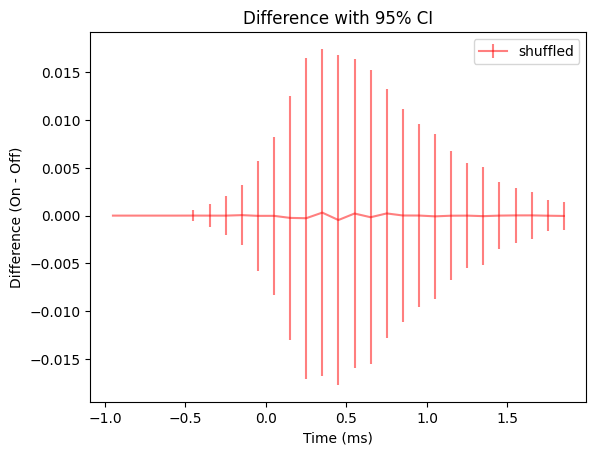

In [10]:
mean = on_minus_off_shuffled.mean(axis=0)
std = on_minus_off_shuffled.std(axis=0)
n = on_minus_off_shuffled.shape[0]
error_95ci = 1.96 * (std)
# Plot with 95% confidence intervals
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')
plt.xlabel('Time (ms)')
plt.ylabel('Difference (On - Off)')
plt.legend()
plt.title('Difference with 95% CI')
plt.show()


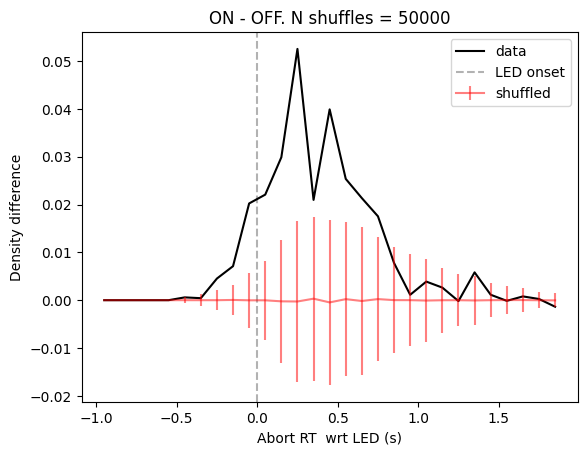

In [11]:
plt.title(f'ON - OFF. N shuffles = {N_shuffles}')
plt.plot(t_pts, abort_on_hist - abort_off_hist, color='k', label='data')
# average across t_pts on_minus_off_shuffled with error bar
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.xlabel('Abort RT  wrt LED (s)')
plt.ylabel('Density difference')
plt.legend()

# t_stim distribution in truncateed LED on and off aborts

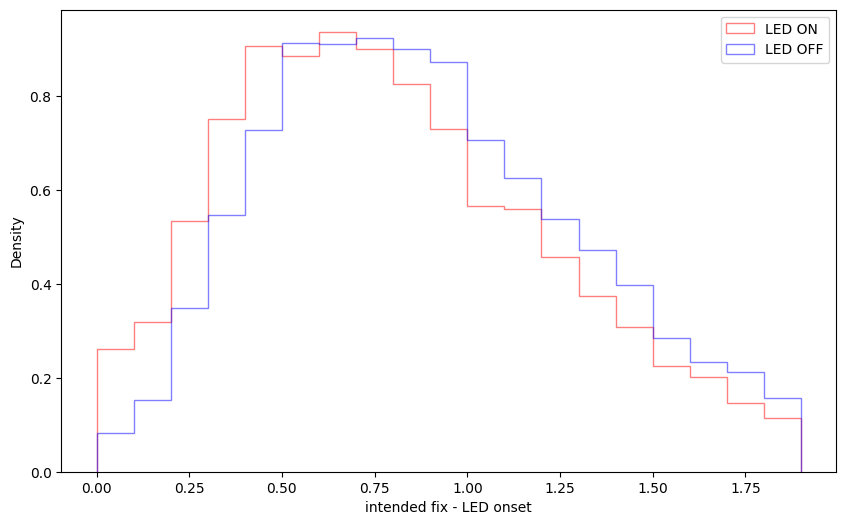

In [12]:
df_led_on_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_truncated_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]

t_stim_led_on_aborts = df_led_on_truncated_aborts['intended_fix'] - df_led_on_truncated_aborts['LED_onset_time']
t_stim_led_off_aborts = df_led_off_truncated_aborts['intended_fix'] - df_led_off_truncated_aborts['LED_onset_time']


plt.figure(figsize=(10, 6))
bin_width = 0.1; bins = np.arange(0, 2, bin_width); t_pts = bins[:-1] + bin_width/2 
plt.hist(t_stim_led_on_aborts, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(t_stim_led_off_aborts, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('intended fix - LED onset')
plt.ylabel('Density')
plt.legend()

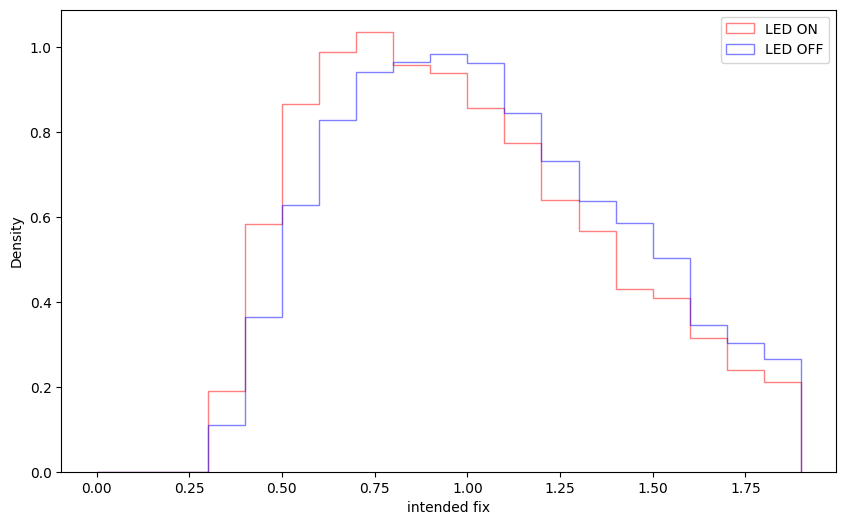

In [13]:
df_led_on_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_truncated_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]

t_stim_led_on_aborts = df_led_on_truncated_aborts['intended_fix']
t_stim_led_off_aborts = df_led_off_truncated_aborts['intended_fix']


plt.figure(figsize=(10, 6))
bin_width = 0.1; bins = np.arange(0, 2, bin_width); t_pts = bins[:-1] + bin_width/2 
plt.hist(t_stim_led_on_aborts, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(t_stim_led_off_aborts, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('intended fix')
plt.ylabel('Density')
plt.legend()

# stratified sampling to match t_stim - t_LED distr?

In [14]:
df_led_on_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_truncated_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]

In [15]:
# Calculate the difference for stratification using .loc
df_led_on_truncated_aborts.loc[:, 'diff'] = df_led_on_truncated_aborts['intended_fix'] - df_led_on_truncated_aborts['LED_onset_time']
df_led_off_truncated_aborts.loc[:, 'diff'] = df_led_off_truncated_aborts['intended_fix'] - df_led_off_truncated_aborts['LED_onset_time']


/tmp/ipykernel_317346/3874799114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_led_on_truncated_aborts.loc[:, 'diff'] = df_led_on_truncated_aborts['intended_fix'] - df_led_on_truncated_aborts['LED_onset_time']
/tmp/ipykernel_317346/3874799114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_led_off_truncated_aborts.loc[:, 'diff'] = df_led_off_truncated_aborts['intended_fix'] - df_led_off_truncated_aborts['LED_onset_time']


In [16]:
# Define the bins for stratification
bins = np.histogram_bin_edges(
    pd.concat([
        df_led_on_truncated_aborts['diff'],
        df_led_off_truncated_aborts['diff']
    ]), bins='auto'
)


In [17]:
# Assign strata based on bins
df_led_on_truncated_aborts.loc[:,'strata'] = pd.cut(df_led_on_truncated_aborts['diff'], bins=bins, labels=False)
df_led_off_truncated_aborts.loc[:, 'strata'] = pd.cut(df_led_off_truncated_aborts['diff'], bins=bins, labels=False)

/tmp/ipykernel_317346/2958187411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_led_on_truncated_aborts.loc[:,'strata'] = pd.cut(df_led_on_truncated_aborts['diff'], bins=bins, labels=False)
/tmp/ipykernel_317346/2958187411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_led_off_truncated_aborts.loc[:, 'strata'] = pd.cut(df_led_off_truncated_aborts['diff'], bins=bins, labels=False)


In [18]:
# Find the minimum count for each stratum
min_count_per_stratum = (
    pd.concat([
        df_led_on_truncated_aborts.groupby('strata').size(),
        df_led_off_truncated_aborts.groupby('strata').size()
    ], axis=1)
    .min(axis=1)
)

In [19]:
# Sample rows from each stratum
df_led_on_truncated_aborts_strata = (
    df_led_on_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

df_led_off_truncated_aborts_strata = (
    df_led_off_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

/tmp/ipykernel_317346/937097667.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
/tmp/ipykernel_317346/937097667.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))


In [20]:
# Drop temporary columns used for stratification
df_led_on_truncated_aborts_strata = df_led_on_truncated_aborts_strata.drop(columns=['diff', 'strata'])
df_led_off_truncated_aborts_strata = df_led_off_truncated_aborts_strata.drop(columns=['diff', 'strata'])

Text(0.5, 1.0, 'Stratified sampling')

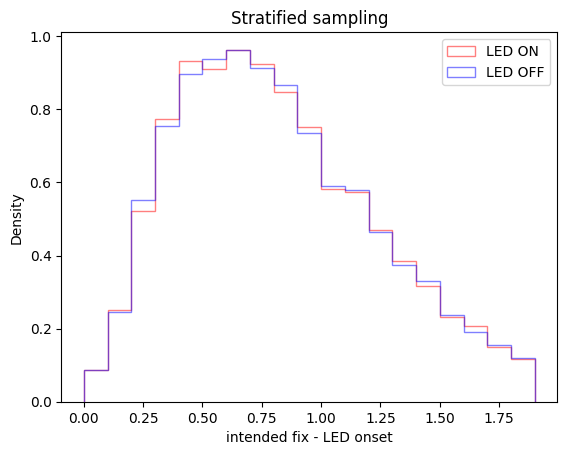

In [21]:
t_stim_aborts_on = df_led_on_truncated_aborts_strata['intended_fix'] - df_led_on_truncated_aborts_strata['LED_onset_time']
t_stim_aborts_off = df_led_off_truncated_aborts_strata['intended_fix'] - df_led_off_truncated_aborts_strata['LED_onset_time']

bin_width = 0.1; bins = np.arange(0, 2, bin_width); t_pts = bins[:-1] + bin_width/2
plt.hist(t_stim_aborts_on, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(t_stim_aborts_off, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('intended fix - LED onset')
plt.ylabel('Density')
plt.legend()
plt.title('Stratified sampling')

In [22]:
# how do their aborts look?
# df_led_on_truncated_aborts_strata timed_fix histogram
bin_width = 0.1; bins = np.arange(-1, 2, bin_width); t_pts = bins[:-1] + bin_width/2
led_on_strata_abort_hist, _ = np.histogram(df_led_on_truncated_aborts_strata['timed_fix'] - df_led_on_truncated_aborts_strata['LED_onset_time'],\
                                            bins=bins, density=True)
led_on_strata_abort_hist *= len(df_led_on_truncated_aborts_strata) / len(df[ df['LED_trial'] == 1])

led_off_strata_abort_hist, _ = np.histogram(df_led_off_truncated_aborts_strata['timed_fix'] - df_led_off_truncated_aborts_strata['LED_onset_time'],\
                                             bins=bins, density=True)
led_off_strata_abort_hist *= len(df_led_off_truncated_aborts_strata) / len(df[ df['LED_trial'] == 0])


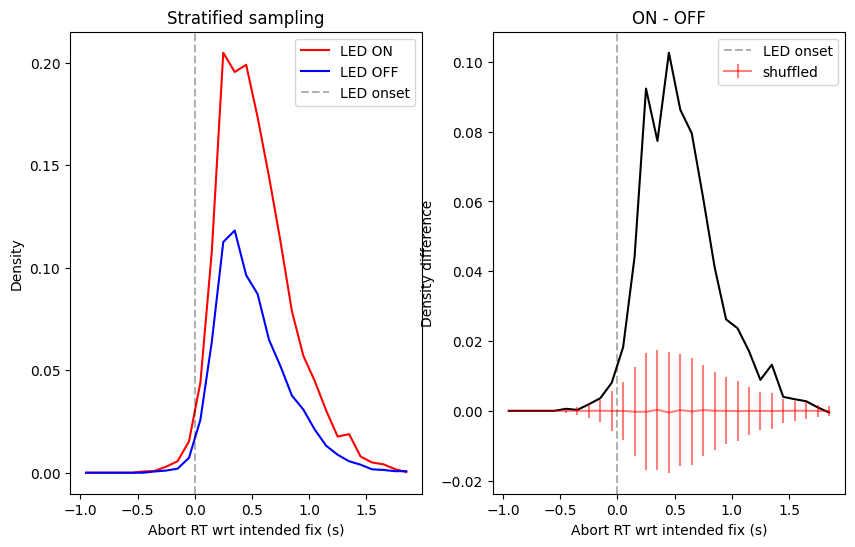

In [23]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(t_pts, led_on_strata_abort_hist, label='LED ON', color='r')
plt.plot(t_pts, led_off_strata_abort_hist, label='LED OFF', color='b')

plt.axvline(0, color='k', linestyle='--', label='LED onset', alpha=0.3)
plt.legend()
plt.xlabel('Abort RT wrt intended fix (s)')
plt.ylabel('Density')
plt.title('Stratified sampling')

plt.subplot(1, 2, 2)
plt.title('ON - OFF')
plt.plot(t_pts, led_on_strata_abort_hist - led_off_strata_abort_hist, color='k')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')

plt.xlabel('Abort RT wrt intended fix (s)')
plt.ylabel('Density difference')
plt.legend()

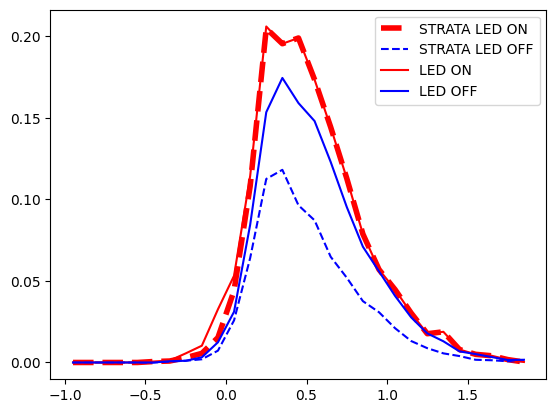

In [24]:
plt.plot(t_pts, led_on_strata_abort_hist, label='STRATA LED ON', color='r', ls='--', lw=4)
plt.plot(t_pts, led_off_strata_abort_hist, label='STRATA LED OFF', color='b', ls='--')

plt.plot(t_pts, abort_on_hist, label='LED ON', color='r')
plt.plot(t_pts, abort_off_hist, label='LED OFF', color='b')
plt.legend()

# do stim and led times change in aborts between on and off?

In [25]:
df_led_on_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_truncated_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]



In [26]:
t_stim_on_aborts = df_led_on_truncated_aborts['intended_fix']
t_stim_off_aborts = df_led_off_truncated_aborts['intended_fix']

led_time_on_aborts = df_led_on_truncated_aborts['LED_onset_time']
led_time_off_aborts = df_led_off_truncated_aborts['LED_onset_time']

diff_on_aborts = t_stim_on_aborts - led_time_on_aborts
diff_off_aborts = t_stim_off_aborts - led_time_off_aborts

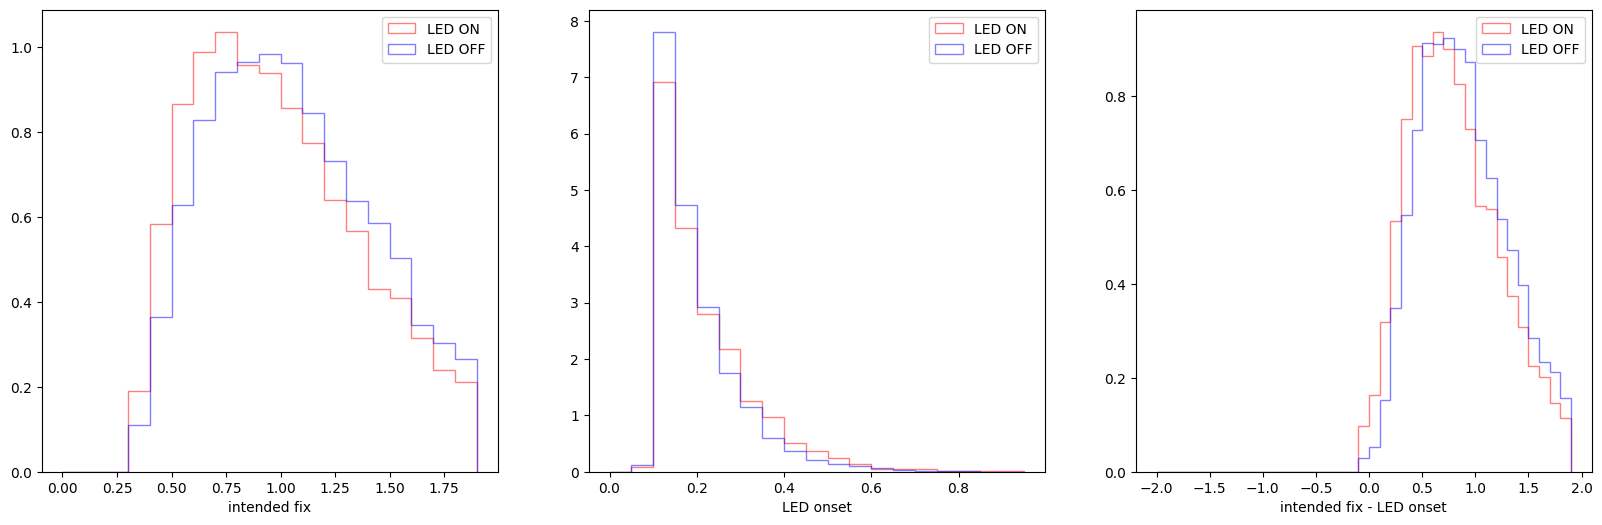

In [27]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
bins = np.arange(0, 2, 0.1)
plt.hist(t_stim_on_aborts, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(t_stim_off_aborts, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('intended fix')
plt.legend()

plt.subplot(1, 3, 2)
bins = np.arange(0, 1, 0.05)
plt.hist(led_time_on_aborts, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(led_time_off_aborts, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('LED onset')
plt.legend()


plt.subplot(1, 3, 3)
bins = np.arange(-2, 2, 0.1)
plt.hist(diff_on_aborts, bins=bins, density=True, alpha=0.5, color='r', label='LED ON', histtype='step')
plt.hist(diff_off_aborts, bins=bins, density=True, alpha=0.5, color='b', label='LED OFF', histtype='step')
plt.xlabel('intended fix - LED onset')
plt.legend()


# stratified based on LED onset 

In [ ]:
# Create filtered copies of the DataFrame (no alteration of original data)
df_led_on_truncated_aborts = df[
    (df['LED_trial'] == 1) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

df_led_off_truncated_aborts = df[
    (df['LED_trial'] == 0) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

# Define bins for stratification
bin_width = 0.05
bins = pd.interval_range(start=df['LED_onset_time'].min(), 
                         end=df['LED_onset_time'].max() + bin_width, 
                         freq=bin_width)

# Assign strata based on bins
df_led_on_truncated_aborts['strata'] = pd.cut(df_led_on_truncated_aborts['LED_onset_time'], bins=bins, labels=False)
df_led_off_truncated_aborts['strata'] = pd.cut(df_led_off_truncated_aborts['LED_onset_time'], bins=bins, labels=False)

# Find the minimum count for each stratum
min_count_per_stratum = (
    pd.concat([
        df_led_on_truncated_aborts.groupby('strata').size(),
        df_led_off_truncated_aborts.groupby('strata').size()
    ], axis=1).min(axis=1)
)

# Perform stratified sampling
df_led_on_sampled = (
    df_led_on_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

df_led_off_sampled = (
    df_led_off_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

# Reset index for the sampled DataFrames (optional)
df_led_on_sampled = df_led_on_sampled.reset_index(drop=True)
df_led_off_sampled = df_led_off_sampled.reset_index(drop=True)




/tmp/ipykernel_317346/96651857.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_on_truncated_aborts.groupby('strata').size(),
/tmp/ipykernel_317346/96651857.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_off_truncated_aborts.groupby('strata').size()
/tmp/ipykernel_317346/96651857.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_on_truncated_aborts.groupby('strata', group_keys=False)
/tm

Text(0.5, 1.0, 'Stratified sampling for LED onset time')

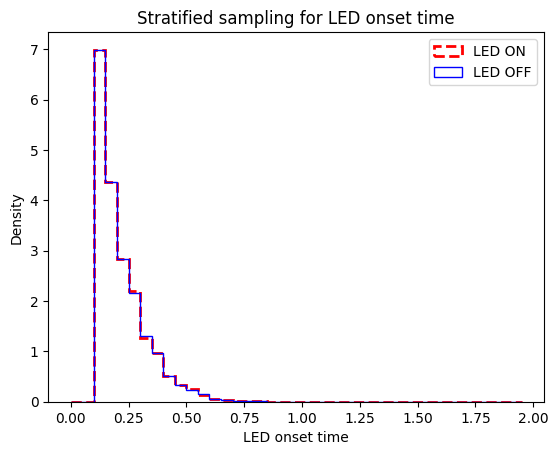

In [29]:
# led_onset_time of sampled data
bins = np.arange(0, 2, 0.05)
plt.hist(df_led_on_sampled['LED_onset_time'], bins=bins, density=True, color='r', lw=2, ls='--', label='LED ON', histtype='step')
plt.hist(df_led_off_sampled['LED_onset_time'], bins=bins, density=True, color='b', label='LED OFF', histtype='step')
plt.xlabel('LED onset time')
plt.ylabel('Density')
plt.legend()
plt.title('Stratified sampling for LED onset time')
